### Import all required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

### Reading the data

In [2]:
# this dataset if for badminton review
review1 = pd.read_csv("data.csv")
review1.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


### Checking the shape of the data
- 8518 rows and 8 features are present in the dataset

In [3]:
review1.shape

(8518, 8)

### Observations from Dataset Info:
Dataset Size: The dataset contains 8518 rows and 8 columns.

**Missing Values:**

Several columns have missing values:

Reviewer Name: 10 missing

Review Title: 10 missing

Place of Review: 50 missing

Up Votes, Down Votes: 10 missing each

Month: 465 missing (the highest)

Review text: 8 missing

**Data Types:**

Numerical columns:

Up Votes and Down Votes are of type float64 (likely due to NaNs).

Ratings is of type int64.

Categorical/Text columns: Reviewer Name, Review Title, Place of Review, Month, and Review text are of type object.

**Potential Issues:**

Missing values will need to be handled before modeling.

Categorical/text data (like Review text) will require encoding or vectorization (e.g., using CountVectorizer or TfidfVectorizer).

Month being an object type may need to be converted to datetime or ordinal format for temporal analysis.

In [4]:
review1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


### Check duplicate values
- 4 duplicate values are present in the dataset

In [5]:
review1.duplicated().sum()

4

### Remove duplicates
- Removing all duplicate records to ensure the integrity and consistency of the dataset.

In [6]:
review1.drop_duplicates(inplace=True)

### Checking duplicate values after removing

In [7]:
review1.duplicated().sum()

0

### Check null values
Several columns have missing values:

Reviewer Name: 6 missing

Review Title: 6 missing

Place of Review: 45 missing

Up Votes, Down Votes: 6 missing each

Month: 461 missing (the highest)

Review text: 4 missing

In [8]:
review1.isna().sum()

Reviewer Name        6
Review Title         6
Place of Review     46
Up Votes             6
Down Votes           6
Month              461
Review text          4
Ratings              0
dtype: int64

### Dropping all the null values

In [9]:
review1.dropna(inplace=True)

### Checking null values after removing

In [10]:
review1.isna().sum()

Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64

### Changing the data types of the features

In [11]:
review1["Up Votes"]=review1["Up Votes"].astype(int)
review1["Down Votes"]=review1["Down Votes"].astype(int)
review1["year"] = review1["Month"].str[-4:]

### Creating new year and month features from existing features

In [12]:
review1["year"]=review1["year"].astype(int)
review1["Month"]=review1["Month"].str.split().str[0]

### Cleaning the text 
- Tokenized the text 
- removed irrelevant words using stopwords
- lemmatized words to their base forms for better normalization.

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+','',text)
    text = re.sub(r'[^\w\s]','',text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words).strip()
    return text

### Apply above function on the dataframe

In [14]:
for i in review1.select_dtypes(include="object"):
    review1[i]=review1[i].apply(clean_text)

### Renaming the dataframe

In [15]:
cleaned_df = review1

### Creating target column using rating 

In [16]:
def assign_ratings(ratings):
    if ratings == 5 or ratings == 4:
        return "Positive"
    else:
        return "Negative"


cleaned_df["Target"]=cleaned_df["Ratings"].apply(assign_ratings)

In [17]:
cleaned_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,year,Target
0,kamal suresh,nice product,certified buyer chirakkal,889,64,feb,nice product good quality price rising bad sig...,4,2021,Positive
1,flipkart customer,dont waste money,certified buyer hyderabad,109,6,feb,didnt supplied yonex mavis outside cover yonex...,1,2021,Negative
2,raja srinivasan,meet expectation,certified buyer dharmapuri,42,3,apr,worst product damaged shuttlecock packed new b...,1,2021,Negative
5,baji sankar,mindblowing purchase,certified buyer hyderabad,173,45,oct,good quality product delivered timeread,5,2018,Positive
6,flipkart customer,must buy,certified buyer doom dooma,403,121,jan,best purchase good quality durable average shu...,5,2020,Positive


### Check the distribution of the target feature

In [18]:
cleaned_df.Target.value_counts()

Target
Positive    6462
Negative    1551
Name: count, dtype: int64

### Visual distribution of the target feature

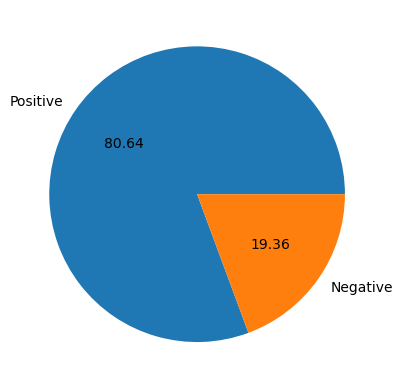

In [19]:
plt.pie(cleaned_df.Target.value_counts().values, labels=cleaned_df.Target.value_counts().index, autopct='%0.2f')
plt.show()

### Using Word cloud
- A Word Cloud was generated to visually represent the most frequently occurring words in the review text.

In [20]:
wc=WordCloud(width=500, height=500, min_font_size=10, background_color='black')

### For positive reviews

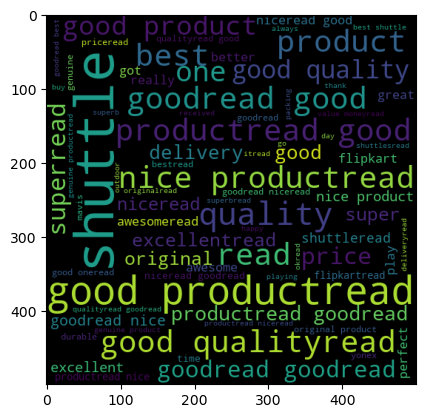

In [21]:
sentiment_wc=wc.generate(cleaned_df[cleaned_df["Target"]=='Positive']["Review text"].str.cat(sep=" "))
plt.imshow(sentiment_wc)

### For negative reviews

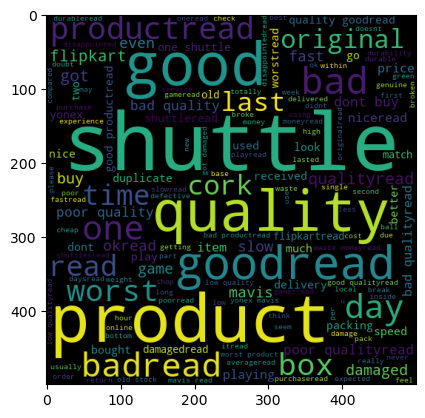

In [22]:
sentiment_wc=wc.generate(cleaned_df[cleaned_df["Target"]=='Negative']["Review text"].str.cat(sep=" "))
plt.imshow(sentiment_wc)

### Convert target feature values to numerical 

In [23]:
cleaned_df['Target'] = cleaned_df['Target'].replace({'Positive':1,'Negative':0}, regex=True)

C:\Users\Manisha\AppData\Local\Temp\ipykernel_7712\2910730347.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_df['Target'] = cleaned_df['Target'].replace({'Positive':1,'Negative':0}, regex=True)


### Use countvectorizer 
- CountVectorizer converts a collection of text documents into a matrix of token counts.
It represents text data as a bag-of-words model, capturing the frequency of each word in the corpus.

In [24]:
cv=CountVectorizer()
tfidf = TfidfVectorizer()

### Separating the data into x and y

In [25]:
x=tfidf.fit_transform(cleaned_df['Review text']).toarray()
y=cleaned_df['Target']

### Splitting the data into training and testing

In [26]:
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=42)

### Instantition of algorithms

In [215]:
raf=RandomForestClassifier(
    n_estimators=300,
    max_depth=22,
    class_weight='balanced',
    random_state=42
)
knn=KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='minkowski',
    algorithm='auto'
)
tree=DecisionTreeClassifier(max_depth=21)
lr=LogisticRegression()
gnb=GaussianNB()
bnb=BernoulliNB()
mnb=MultinomialNB()

### Logistic Regression

In [116]:
lr.fit(x_train, y_train)

LogisticRegression()

In [117]:
y_pred=lr.predict(x_test)

In [118]:
print(accuracy_score(y_test, y_pred))

0.8777292576419214


In [119]:
print(precision_score(y_test, y_pred))

0.8758620689655172


In [120]:
print(confusion_matrix(y_test, y_pred))

[[ 137  180]
 [  16 1270]]


In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.43      0.58       317
           1       0.88      0.99      0.93      1286

    accuracy                           0.88      1603
   macro avg       0.89      0.71      0.76      1603
weighted avg       0.88      0.88      0.86      1603



### KNN

In [122]:
knn.fit(x_train, y_train)

KNeighborsClassifier(weights='distance')

In [123]:
y_pred=knn.predict(x_test)

In [124]:
print(accuracy_score(y_test, y_pred))

0.868995633187773


In [125]:
print(precision_score(y_test, y_pred))

0.8794076163610719


In [126]:
print(confusion_matrix(y_test, y_pred))

[[ 146  171]
 [  39 1247]]


In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.46      0.58       317
           1       0.88      0.97      0.92      1286

    accuracy                           0.87      1603
   macro avg       0.83      0.72      0.75      1603
weighted avg       0.86      0.87      0.85      1603



### decision tree

In [188]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=21)

In [189]:
y_pred=tree.predict(x_test)

In [190]:
print(accuracy_score(y_test, y_pred))

0.877105427323768


In [191]:
print(precision_score(y_test, y_pred))

0.8880969351389879


In [192]:
print(confusion_matrix(y_test, y_pred))

[[ 160  157]
 [  40 1246]]


In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.50      0.62       317
           1       0.89      0.97      0.93      1286

    accuracy                           0.88      1603
   macro avg       0.84      0.74      0.77      1603
weighted avg       0.87      0.88      0.87      1603



### random forest

In [216]:
raf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=22, n_estimators=300,
                       random_state=42)

In [217]:
y_pred=raf.predict(x_test)

In [218]:
print(accuracy_score(y_test, y_pred))

0.8777292576419214


In [219]:
print(precision_score(y_test, y_pred))

0.9205246913580247


In [220]:
print(confusion_matrix(y_test, y_pred))

[[ 214  103]
 [  93 1193]]


In [221]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       317
           1       0.92      0.93      0.92      1286

    accuracy                           0.88      1603
   macro avg       0.81      0.80      0.80      1603
weighted avg       0.88      0.88      0.88      1603



### Gaussian naive bayes

In [140]:
gnb.fit(x_train, y_train)

GaussianNB()

In [141]:
y_pred=gnb.predict(x_test)

In [142]:
print(accuracy_score(y_test, y_pred))

0.3237679351216469


In [143]:
print(precision_score(y_test, y_pred))

0.8531468531468531


In [144]:
print(confusion_matrix(y_test, y_pred))

[[ 275   42]
 [1042  244]]


In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.87      0.34       317
           1       0.85      0.19      0.31      1286

    accuracy                           0.32      1603
   macro avg       0.53      0.53      0.32      1603
weighted avg       0.73      0.32      0.32      1603



### binomial naive bayes

In [146]:
bnb.fit(x_train, y_train)

BernoulliNB()

In [147]:
y_pred=bnb.predict(x_test)

In [148]:
print(accuracy_score(y_test, y_pred))

0.8346849656893325


In [149]:
print(precision_score(y_test, y_pred))

0.8607773851590106


In [150]:
print(confusion_matrix(y_test, y_pred))

[[ 120  197]
 [  68 1218]]


In [151]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.38      0.48       317
           1       0.86      0.95      0.90      1286

    accuracy                           0.83      1603
   macro avg       0.75      0.66      0.69      1603
weighted avg       0.82      0.83      0.82      1603



### Multinomial naive bayes

In [152]:
mnb.fit(x_train, y_train)

MultinomialNB()

In [153]:
y_pred=mnb.predict(x_test)

In [154]:
print(accuracy_score(y_test, y_pred))

0.8627573300062383


In [155]:
print(precision_score(y_test, y_pred))

0.8620923913043478


In [156]:
print(confusion_matrix(y_test, y_pred))

[[ 114  203]
 [  17 1269]]


In [157]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.36      0.51       317
           1       0.86      0.99      0.92      1286

    accuracy                           0.86      1603
   macro avg       0.87      0.67      0.71      1603
weighted avg       0.86      0.86      0.84      1603



In [222]:
import joblib

In [223]:
with open("raf_model.pkl",'wb') as f:
    joblib.dump(raf,f)

In [224]:
with open("raf_model.pkl", 'rb') as f:
    raf_model=joblib.load(f)

In [231]:
sample= "best product quality durable"
sample1="worst quality of the product"

In [232]:
sample=tfidf.transform([sample]).toarray()
sample1=tfidf.transform([sample1]).toarray()

In [234]:
label_map = {0: 'Negative', 1: 'Positive'}
pred = raf_model.predict(sample1)[0]
print(label_map[pred])

Negative
